# Markstein numbers (phi = 0.4) from Cantera

This notebook mirrors `markstein_cantera_original.ipynb` but follows the paper procedure for
reference quantities, activation energy, and Markstein numbers for `phi = 0.4`.

## Scaling and reference quantities
The paper uses the thermal flame thickness and laminar flame speed as reference scales:

$$\ell_T = \frac{T_b - T_u}{\max(\nabla T)}, \quad t_{ref} = \frac{\ell_T}{S_L}$$

Reference heat release rate and mixture transport scales are:

$$\dot{Q}_u = \frac{\rho_u c_{p,u} T_u}{t_{ref}}, \quad D_{th} = \frac{\lambda_u}{\rho_u c_{p,u}}, \quad \ell_f = \frac{D_{th}}{S_L}$$

Scaled temperature and heat release rate are:

$$\Theta = \frac{T - T_u}{T_b - T_u}, \quad \Xi = \frac{\dot{Q} - \dot{Q}_u}{\dot{Q}_{max} - \dot{Q}_u}$$

Activation energy (local Arrhenius fit near peak heat release):

$$E_a = -R\,\frac{d[\ln(\dot{\omega}_T)]}{d(1/T)}$$

Zeldovich number (paper definition):

$$\beta = \frac{E_a (T_b - T_u)}{R T_b^2}$$

Markstein numbers from Eq. (30)-(31) in `markstein_cantera_original.ipynb`:

$$\alpha = \frac{\sigma}{\sigma - 1} \int_{1}^{\sigma} \frac{\tilde{\lambda}(x)}{x} \, dx
+ \frac{\beta}{2} \frac{Le_{eff} - 1}{\sigma - 1} \int_{1}^{\sigma} \frac{\tilde{\lambda}(x)}{x} \, \ln\left(\frac{\sigma - 1}{x - 1}\right) dx$$

$$\begin{aligned}
L_{str}^* &= \left[ \alpha \int_{1}^{\tilde{T}^*} \frac{\tilde{\lambda}(x)}{x} \, dx - \int_{\tilde{T}^*}^{\sigma} \frac{\tilde{\lambda}(x)}{x - 1} \, dx \right] \\
L_{cur}^* &= \left[ \alpha \int_{1}^{\tilde{T}^*} \frac{\tilde{\lambda}(x)}{x} \, dx \right]
\end{aligned}$$

with $x = T/T_u$, $\tilde{\lambda} = \lambda/\lambda_u$, and $\sigma = \rho_u/\rho_b$.

Effective Lewis number (Eq. 2.3):

$$Le_{eff} = \frac{Le_E + A\,Le_D}{1 + A}, \quad
A = \begin{cases}
1 + \beta(\phi^{-1} - 1), & \phi < 1 \\
1 + \beta(\phi - 1), & \phi > 1
\end{cases}$$

Here $Le_D$ and $Le_E$ are the Lewis numbers of the deficient and excess reactants, respectively.

Markstein number (Eq. 2.17) and burned Markstein number (Eq. 2.19):

$$\mathcal{M} = \frac{\sigma}{\sigma - 1} \int_{1}^{\sigma} \frac{\tilde{\lambda}(x)}{x} \, dx
+ \frac{\beta}{2} \frac{Le_{eff} - 1}{\sigma - 1} \int_{1}^{\sigma} \frac{\tilde{\lambda}(x)}{x} \, \ln\left(\frac{\sigma - 1}{x - 1}\right) dx$$

$$\mathcal{M}^b = \mathcal{M} - \int_{1}^{\sigma} \frac{\tilde{\lambda}(x)}{x} \, dx$$

with $L = \mathcal{M} \, \ell_f$ and $L^b = \mathcal{M}^b \, \ell_f$.

## Assumptions (explicit)
- 1D, steady, planar, freely propagating premixed flame at constant pressure; ideal gas.
- Transport model is mixture-averaged (Cantera default). Thermal conductivity and species
  diffusivities are taken directly from Cantera; no constant-transport simplification.
- Activation energy is from a local Arrhenius fit to the heat-release-rate profile.
- Optional override: set `USE_FIXED_EA=True` to bypass the fit and use `EA_FIXED_KCAL_PER_MOL`.
- Effective Lewis number uses fuel and oxidizer Lewis numbers at unburned conditions with
  Eq. (2.3) weighting.
- Markstein numbers are evaluated at $T^*$ where $\dot{Q}$ is maximum (corresponding to $\Theta^*$).

If you want a different activation-energy model or evaluation point for $L_{str}^*$ and
$L_{cur}^*$, adjust the settings in the next cell.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cantera as ct
import math
import yaml
# ---------------------------
# User settings
# ---------------------------

# Whether to compute full Markstein-length profiles vs progress (useful for plots).
# If False, the notebook computes ONLY the values at PROGRESS_QUERY.
COMPUTE_PROFILE = True

# Non-dimensionalization length scale for Markstein numbers:
#   'LD' -> L_D = D_th / S_L  (diffusive length, matches MarksteinLengths_Chaudhuri.ma)
#   'LT' -> L_T = (T_b - T_u)/max|dT/dx| (thermal thickness from the solved flame)
NONDIM_SCALE = 'LT'  # choose 'LD' or 'LT'

# Plot dimensionless Markstein numbers instead of dimensional lengths.
PLOT_NONDIM = True

def find_project_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "applications").is_dir() and (p / "FLAME").is_dir():
            return p
    return start

PROJECT_ROOT = find_project_root(Path.cwd())

def find_mech_path() -> Path:
    candidates = [
        PROJECT_ROOT / "FLAME" / "chem_mech" / "BurkeH2.yaml",
        PROJECT_ROOT / "FLAME" / "chemical_mech" / "BurkeH2.yaml",
    ]
    for path in candidates:
        if path.is_file():
            return path
    raise FileNotFoundError("BurkeH2.yaml not found under FLAME/chemical_mech")

MECH_PATH = find_mech_path()
PHI = 0.4
T_U = 298.0
P_U = ct.one_atm
FUEL = 'H2'
OXIDIZER = 'O2:1.0, N2:3.76'

TRANSPORT_MODEL = 'mixture-averaged'  # 'mixture-averaged' 

WIDTH = 1e-03#400 * 7.478284e-04  # m
REFINE_CRIT = dict(ratio=3, slope=0.06, curve=0.12)

USE_FIXED_LEWIS = True
LE_FUEL_FIXED = 0.33
LE_OXIDIZER_FIXED = 2.32

USE_FIXED_EA = True
EA_FIXED_KCAL_PER_MOL = 28.7  # kcal/mol (override when USE_FIXED_EA=True)

# Markstein-length convention (to match MarksteinLengths_Chaudhuri.ma)
# -------------------------------------------------------------------
# The Mathematica implementation uses:
#   lambda(x) = x^0.61,   x = T/Tu,   sigma = Tb/Tu
# and a split at a chosen reference location. Here you set it via progress variable c*.
LAMBDA_MODEL = "powerlaw"   # "powerlaw" (matches .ma) or "cantera"
LAMBDA_POWER = 0.61         # exponent for lambda(x) = x^LAMBDA_POWER
STAR_LOCATION = "progress"   # choose where to report star values: "progress" or "qdot_max"
PROGRESS_STAR = 0.6        # c* in [0,1] if STAR_LOCATION="progress"

# ---------------------------
# Plot style (load from Model_verification.yaml)
# ---------------------------
MODEL_VERIF_CONFIG_PATH = PROJECT_ROOT / 'applications' / 'case_studies' / 'Model_verification' / 'Model_verification.yaml'
GLOBAL_PLOT_STYLE_PATH = PROJECT_ROOT / 'applications' / 'case_studies' / 'plot_style.yaml'
PLOT_STYLE_CFG = yaml.safe_load(GLOBAL_PLOT_STYLE_PATH.read_text(encoding='utf-8')) if GLOBAL_PLOT_STYLE_PATH.exists() else {}
MODEL_VERIF_LOCAL_CFG = yaml.safe_load(MODEL_VERIF_CONFIG_PATH.read_text(encoding='utf-8'))
MODEL_VERIF_CFG = dict(PLOT_STYLE_CFG)
MODEL_VERIF_CFG.update(MODEL_VERIF_LOCAL_CFG)

PLOT_FONT_FAMILY = str(MODEL_VERIF_CFG.get('PLOT_FONT_FAMILY', 'Courier New'))
PLOT_FONT_SIZE = int(MODEL_VERIF_CFG.get('PLOT_FONT_SIZE', 20))
FIG_DPI = int(MODEL_VERIF_CFG.get('FIG_DPI', 250))
FIG_SIZE_RAW = MODEL_VERIF_CFG.get('FIG_SIZE', (6.8, 6.2))
if isinstance(FIG_SIZE_RAW, (list, tuple)) and len(FIG_SIZE_RAW) == 2:
    FIG_SIZE = (float(FIG_SIZE_RAW[0]), float(FIG_SIZE_RAW[1]))
else:
    FIG_SIZE = (6.8, 6.2)
FIG_TOP_PAD = 0.93

PLOT_USE_TEX = bool(MODEL_VERIF_CFG.get('PLOT_USE_TEX', False))
PLOT_TEX_PREAMBLE_RAW = MODEL_VERIF_CFG.get('PLOT_TEX_PREAMBLE', '')
if isinstance(PLOT_TEX_PREAMBLE_RAW, (list, tuple)):
    PLOT_TEX_PREAMBLE = '\n'.join(str(item) for item in PLOT_TEX_PREAMBLE_RAW if item)
else:
    PLOT_TEX_PREAMBLE = str(PLOT_TEX_PREAMBLE_RAW) if PLOT_TEX_PREAMBLE_RAW is not None else ''

COLOR_DATA = str(MODEL_VERIF_CFG.get('COLOR_DATA', '#77b5b6'))
COLOR_PRED = str(MODEL_VERIF_CFG.get('COLOR_PRED', '#9671bd'))
COLOR_LINE = str(MODEL_VERIF_CFG.get('COLOR_LINE', '#8a8a8a'))
SCATTER_LINEWIDTH = float(MODEL_VERIF_CFG.get('SCATTER_LINEWIDTH', 0.5))
LINE_WIDTH = 2.2

SAVE_PLOTS = True
PLOT_OUT_DIR = PROJECT_ROOT / 'report_figures' / 'case_studies' / 'Model_verification' / 'Markstein_lengths'


def apply_plot_style() -> None:
    params = {
        'font.family': PLOT_FONT_FAMILY,
        'font.size': PLOT_FONT_SIZE,
        'axes.titlesize': PLOT_FONT_SIZE,
        'axes.labelsize': PLOT_FONT_SIZE,
        'xtick.labelsize': PLOT_FONT_SIZE,
        'ytick.labelsize': PLOT_FONT_SIZE,
        'legend.fontsize': PLOT_FONT_SIZE,
        'figure.titlesize': PLOT_FONT_SIZE,
        'axes.linewidth': 1.2,
        'text.usetex': PLOT_USE_TEX,
        'figure.subplot.left': 0.14,
        'figure.subplot.right': 0.86,
        'figure.subplot.bottom': 0.14,
        'figure.subplot.top': 0.96,
    }
    if PLOT_TEX_PREAMBLE:
        params['text.latex.preamble'] = PLOT_TEX_PREAMBLE
    plt.rcParams.update(params)


def style_axes(ax, *, equal: bool = False) -> None:
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
    ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', length=6, width=1.0)
    ax.tick_params(axis='both', which='minor', length=3, width=0.8)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    if equal:
        ax.set_aspect('equal', adjustable='box')


def style_right_axis(ax) -> None:
    ax.minorticks_on()
    ax.grid(False)
    ax.tick_params(axis='y', which='both', direction='in', right=True)
    ax.tick_params(axis='y', which='major', length=6, width=1.0)
    ax.tick_params(axis='y', which='minor', length=3, width=0.8)
    if 'right' in ax.spines:
        ax.spines['right'].set_linewidth(1.2)


def save_multi_fig(fig, base: Path, suffix: str) -> None:
    out = base.with_name(f"{base.name}_{suffix}")
    out.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out.with_suffix('.png'), dpi=FIG_DPI)
    fig.savefig(out.with_suffix('.pdf'))
    fig.savefig(out.with_suffix('.svg'))


apply_plot_style()


In [2]:
def solve_flame(phi: float, oxidizer: str, loglevel: int = 1) -> ct.FreeFlame:
    gas = ct.Solution(str(MECH_PATH))
    gas.TP = T_U, P_U
    gas.transport_model = TRANSPORT_MODEL
    gas.set_equivalence_ratio(phi, fuel=FUEL, oxidizer=oxidizer)

    flame = ct.FreeFlame(gas, width=WIDTH)
    flame.transport_model = TRANSPORT_MODEL
    flame.set_refine_criteria(**REFINE_CRIT)
    flame.solve(loglevel=loglevel, auto=True)
    return flame


def estimate_activation_energy(flame: ct.FreeFlame, window: int = 8) -> float:
    T = flame.T
    qdot = flame.heat_release_rate
    qdot = np.clip(qdot, 1e-30, None)
    idx_peak = int(np.argmax(qdot))

    i0 = max(0, idx_peak - window)
    i1 = min(len(T), idx_peak + window + 1)
    T_w = T[i0:i1]
    q_w = qdot[i0:i1]

    x = 1.0 / T_w
    y = np.log(q_w)
    slope = np.polyfit(x, y, 1)[0]
    return float(-slope * ct.gas_constant)


def lewis_numbers_unburned(phi: float) -> dict:
    gas = ct.Solution(str(MECH_PATH))
    gas.TP = T_U, P_U
    gas.transport_model = TRANSPORT_MODEL
    gas.set_equivalence_ratio(phi, fuel=FUEL, oxidizer=OXIDIZER)

    k_u = gas.thermal_conductivity
    rho_u = gas.density
    cp_u = gas.cp_mass
    d_th_u = k_u / (rho_u * cp_u)

    d_mix = gas.mix_diff_coeffs
    i_fuel = gas.species_index(FUEL)
    i_ox = gas.species_index('O2')

    le_f = d_th_u / d_mix[i_fuel]
    le_o = d_th_u / d_mix[i_ox]
    return {
        'Le_fuel': float(le_f),
        'Le_oxidizer': float(le_o),
    }


def effective_lewis_number(phi: float, beta: float, le_fuel: float, le_oxidizer: float) -> float:
    if phi < 1.0:
        le_d = le_fuel
        le_e = le_oxidizer
        A = 1.0 + beta * (1.0 / phi - 1.0)
    elif phi > 1.0:
        le_d = le_oxidizer
        le_e = le_fuel
        A = 1.0 + beta * (phi - 1.0)
    else:
        le_d = le_fuel
        le_e = le_oxidizer
        A = 1.0
    return (le_e + A * le_d) / (1.0 + A)


def compute_reference_quantities(flame: ct.FreeFlame) -> dict:
    T = flame.T
    grid = flame.grid
    rho = flame.density
    k = flame.thermal_conductivity
    cp = flame.cp_mass
    qdot = flame.heat_release_rate

    T_b = float(T[-1])
    T_u = float(T[0])
    S_L = float(flame.velocity[0])
    rho_u = float(rho[0])
    rho_b = float(rho[-1])
    sigma = rho_u / rho_b

    dTdx = np.gradient(T, grid)
    max_grad = float(np.max(np.abs(dTdx)))
    l_T = (T_b - T_u) / max_grad
    t_ref = l_T / S_L

    k_u = float(k[0])
    cp_u = float(cp[0])
    d_th_u = k_u / (rho_u * cp_u)
    l_f = d_th_u / S_L

    Qdot_u = rho_u * cp_u * T_u / t_ref
    Qdot_max = float(np.max(qdot))
    i_qmax = int(np.argmax(qdot))
    T_star = float(T[i_qmax])
    theta_star = (T_star - T_u) / (T_b - T_u)

    Theta = (T - T_u) / (T_b - T_u)
    Xi = (qdot - Qdot_u) / (Qdot_max - Qdot_u)

    return {
        'T_u': T_u,
        'T_b': T_b,
        'S_L': S_L,
        'rho_u': rho_u,
        'rho_b': rho_b,
        'sigma': sigma,
        'l_T': l_T,
        't_ref': t_ref,
        'D_th': d_th_u,
        'l_f': l_f,
        'Qdot_u': Qdot_u,
        'Qdot_max': Qdot_max,
        'T_star': T_star,
        'theta_star': theta_star,
        'T': T,
        'qdot': qdot,
        'Theta': Theta,
        'Xi': Xi,
        'k': k,
        'cp': cp,
    }



************ Solving on 8 point grid with energy equation enabled ************

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 5.695e-05  log(ss)= 5.675     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.0009731  log(ss)= 4.448     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.0003079  log(ss)= 5.26      

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 2.258e-08  log(ss)= 4.858     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 1.242e-12  log(ss)= 4.858     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps

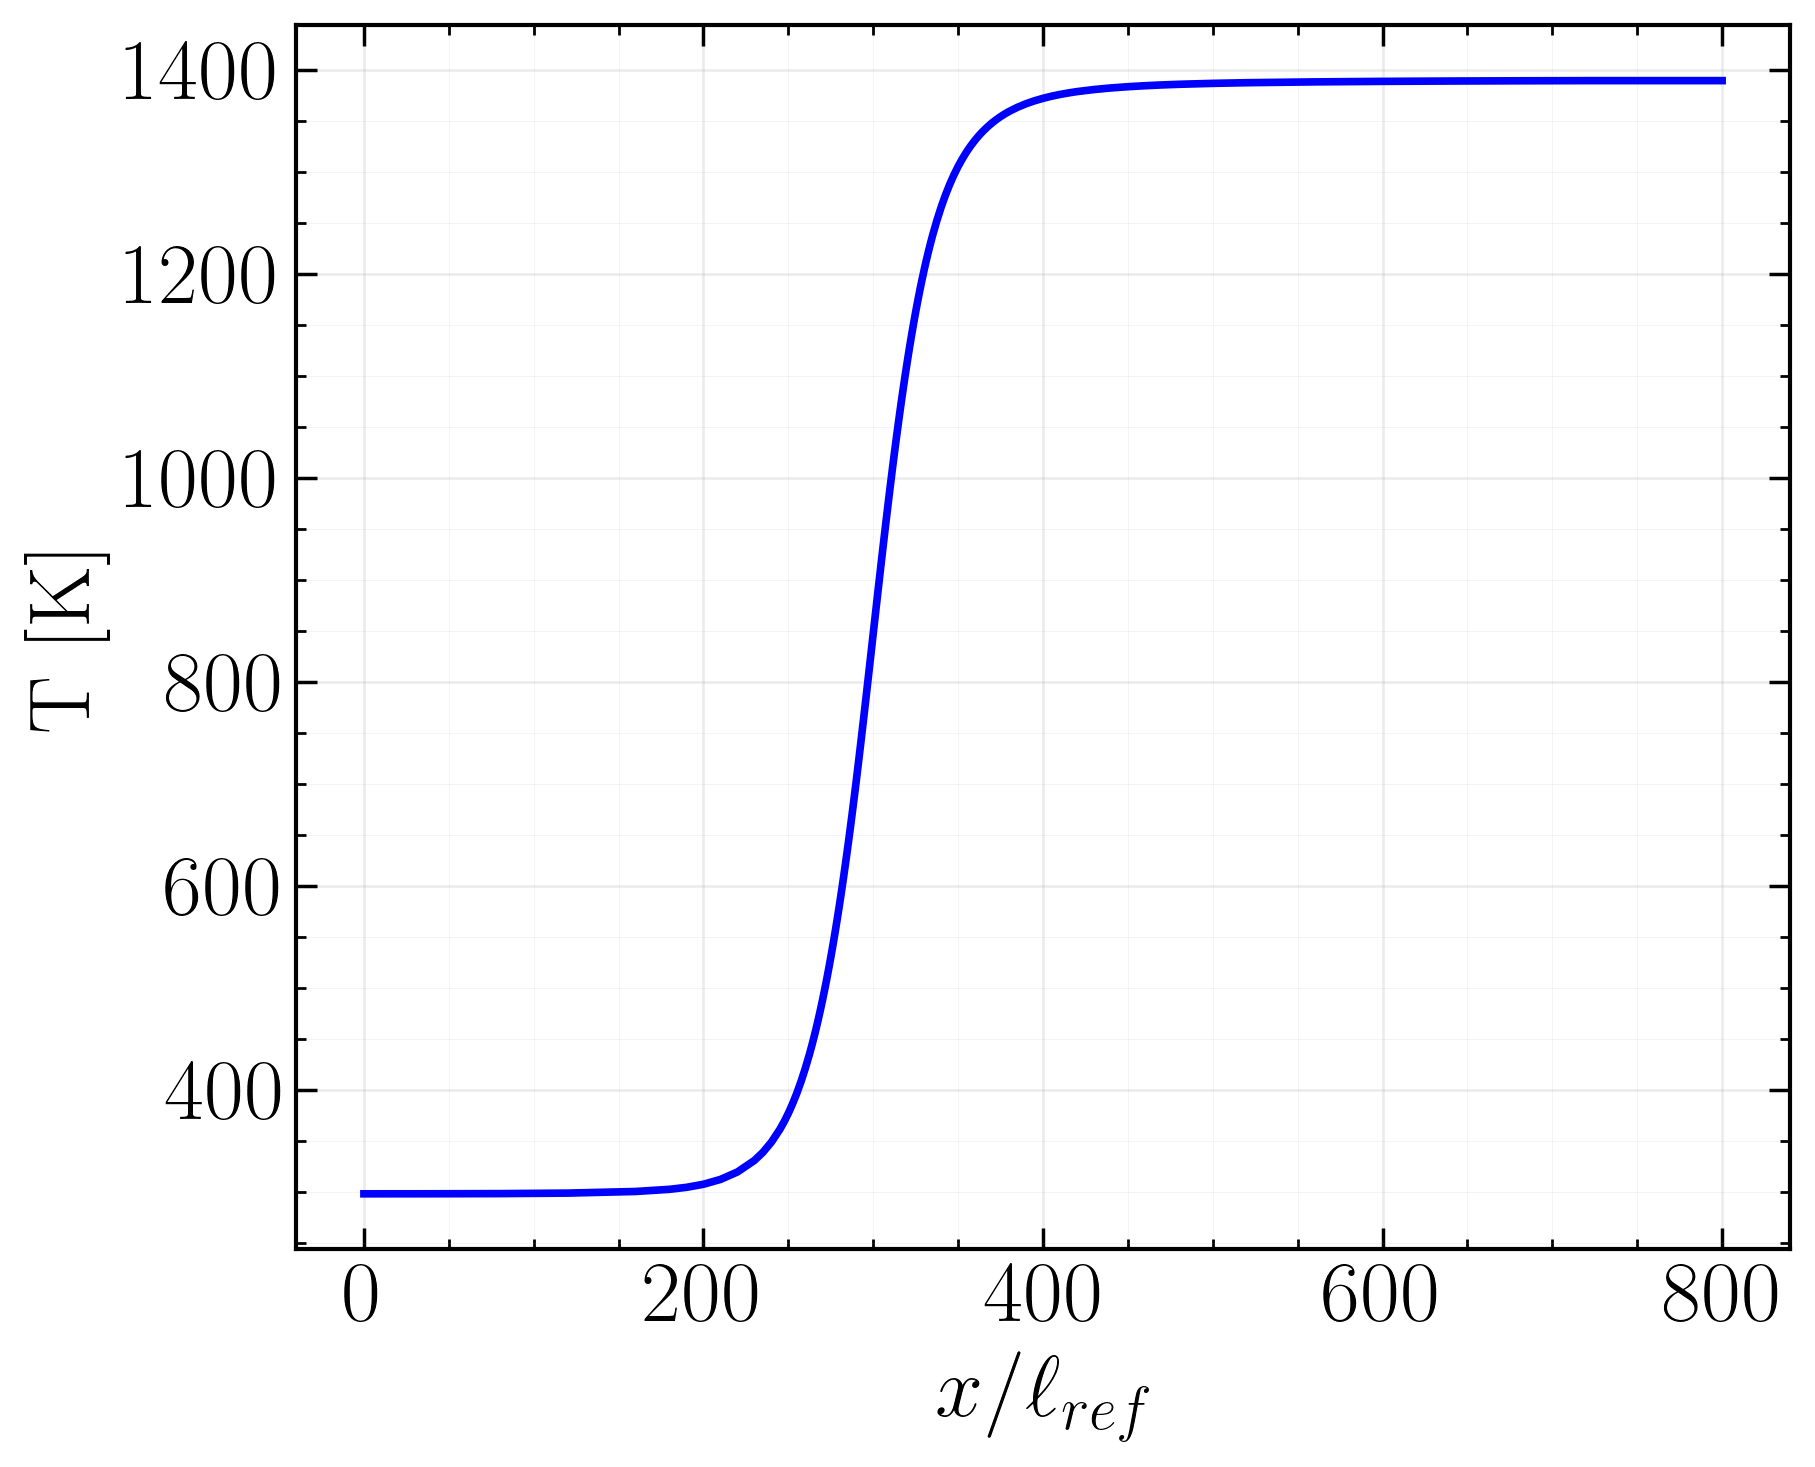

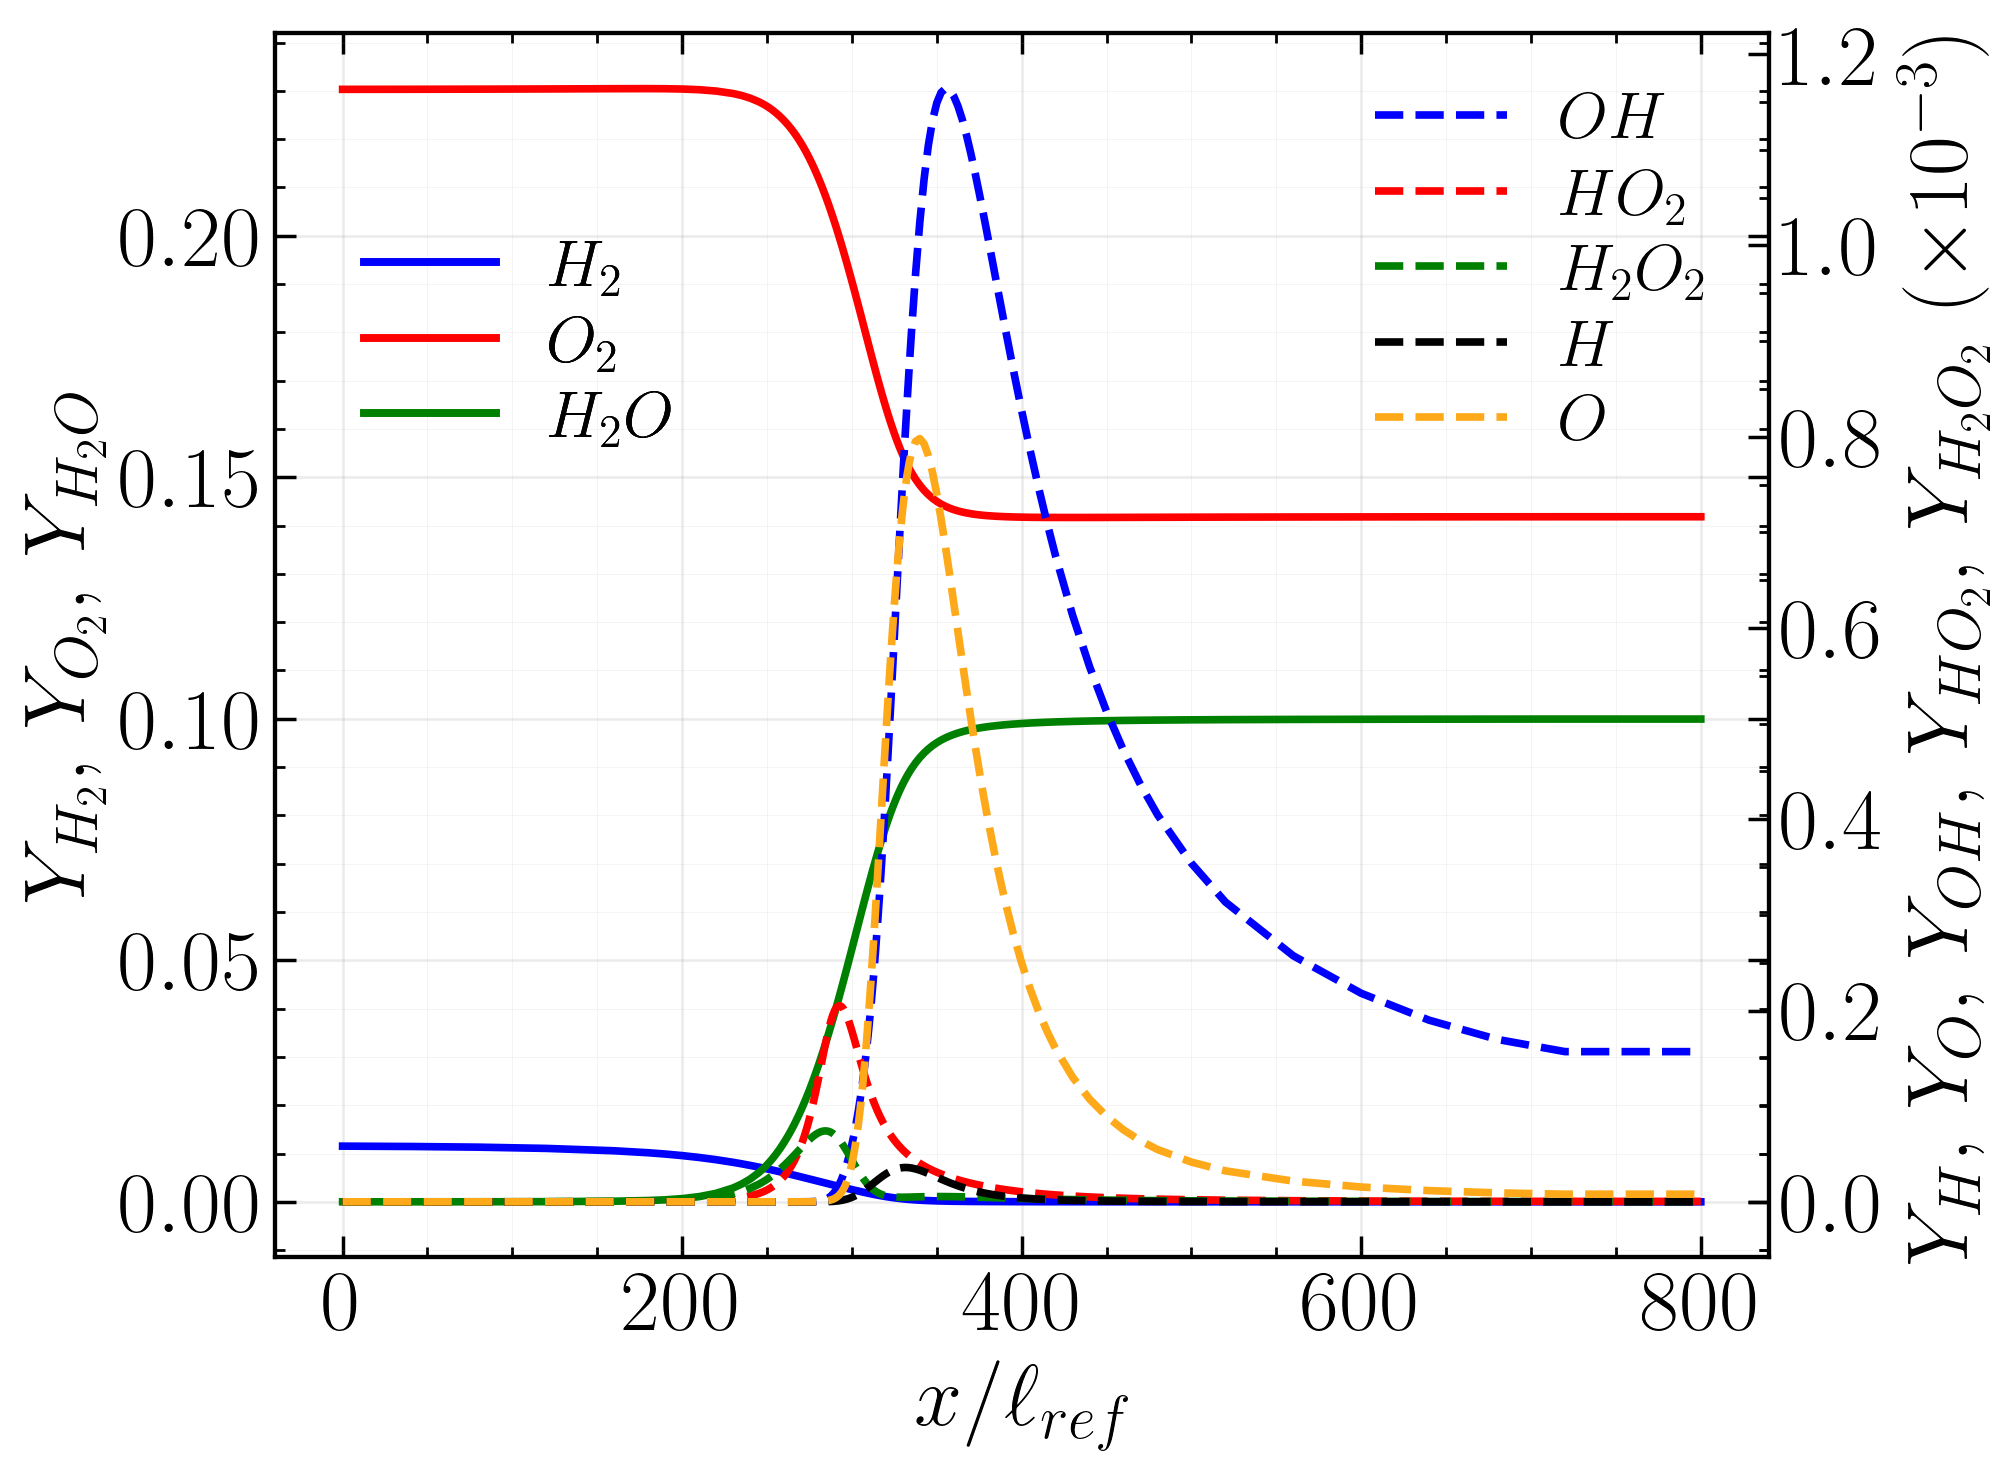

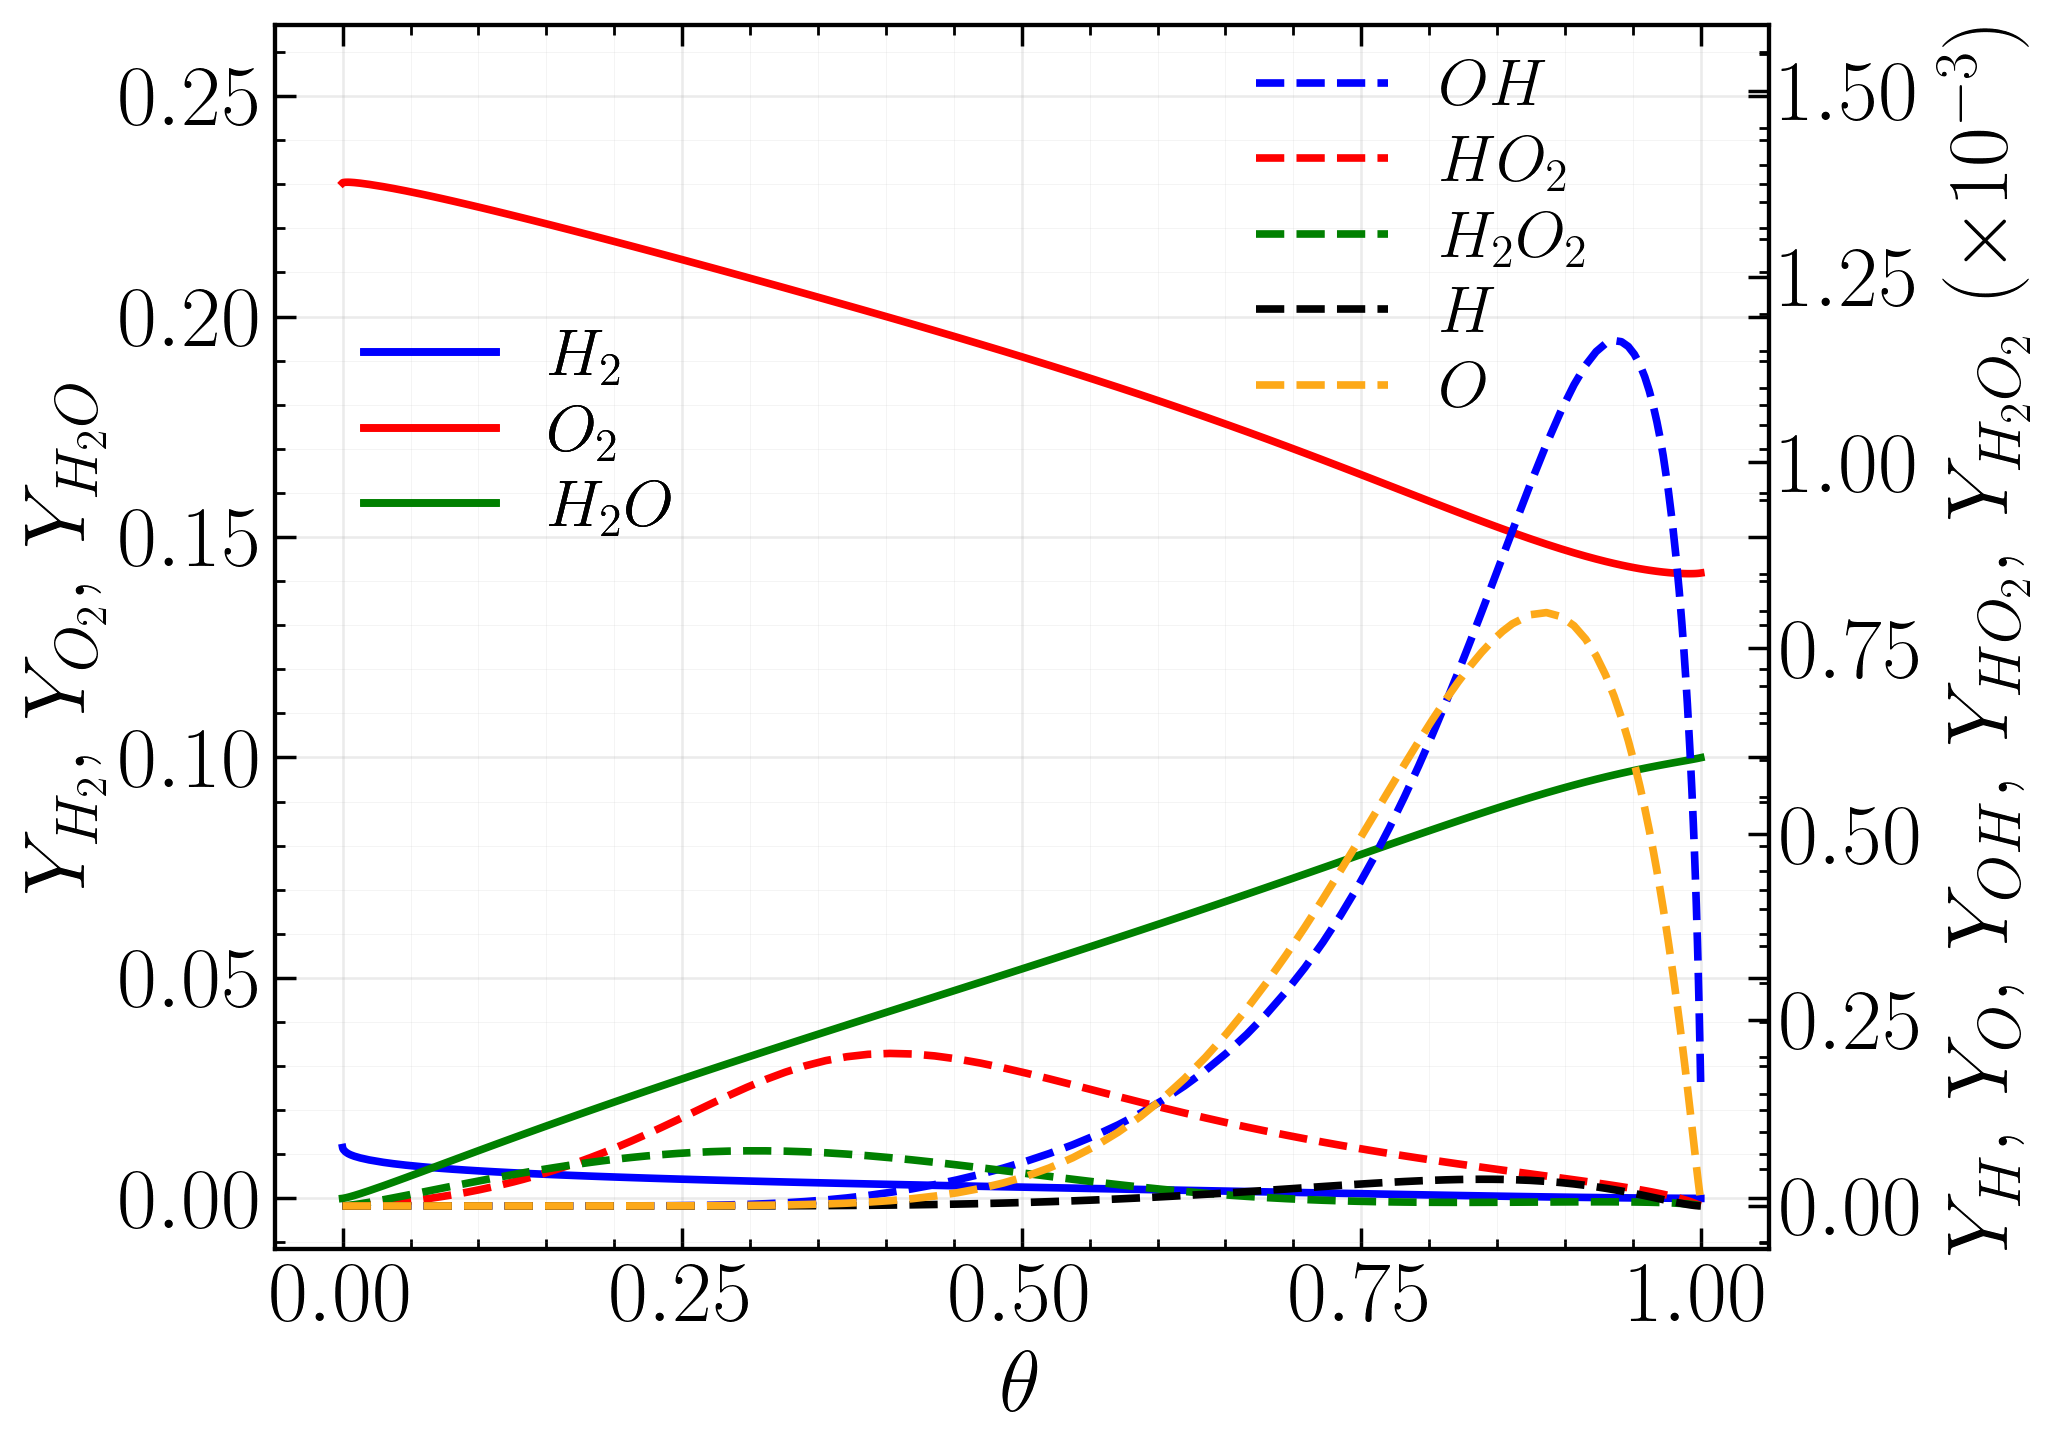

Reference quantities (phi = 0.4)
T_b = 1389.13 K
S_L = 0.180159 m/s
S_L = 18.015929 cm/s
l_T = 7.350319e-02 cm
l_T = 7.350319e-04 m, t_ref = 4.079900e-03 s
sigma = 4.3200
D_th = 3.329247e-05 m^2/s, l_f = 1.847946e-04 m
Qdot_u = 8.687923e+07 W/m^3
Qdot_max = 4.734932e+08 W/m^3
T_star = 1113.30 K, theta_star = 0.7472

Activation energy and Lewis numbers
E_a (fixed) = 28.700000 kcal/mol
beta = 8.1664
Le_fuel = 0.330, Le_oxidizer = 2.320, Le_eff = 0.470


In [3]:
# Solve base flame (phi = 0.4)
flame = solve_flame(PHI, OXIDIZER, loglevel=1)
refs = compute_reference_quantities(flame)

plot_base = PLOT_OUT_DIR / f"markstein_phi_{PHI:.2f}".replace('.', 'p')

# Cantera solution: temperature profile vs x
if NONDIM_SCALE.upper() == 'LD':
    l_ref_plot = refs['D_th'] / refs['S_L']
else:
    l_ref_plot = refs['l_T']

x_plot =  1e05 * flame.grid

fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=False)
ax.plot(x_plot, flame.T, color='blue', linewidth=LINE_WIDTH)
ax.set_xlabel(r'$x / \ell_{ref}$')
ax.set_ylabel('T [K]')

style_axes(ax)
fig.subplots_adjust(top=FIG_TOP_PAD)
if SAVE_PLOTS:
    save_multi_fig(fig, plot_base, 'temperature_vs_x')
plt.show()
plt.close(fig)

# Cantera solution: species mass fractions vs x and progress variable
Y = flame.Y
species_names = flame.gas.species_names
name_to_idx = {name: i for i, name in enumerate(species_names)}

# Left axis species: major species (own y-scale)
left_species = ['H2', 'O2', 'H2O']
left_colors = {
    'H2': 'blue',
    'O2': 'red',
    'H2O': 'green',
}

# Right axis species: radicals/minor species (own y-scale, dotted)
right_species = [ 'OH','HO2', 'H2O2','H', 'O']
right_colors = {
    'H': '#000000',      # black
    'O': "#fda919",      # red
    'OH': 'blue',# '#1f77b4',     # blue
    'HO2': 'red',    # green
    'H2O2': 'green',   # orange
}

species_labels_latex = {
    'H2': r'$H_2$',
    'O2': r'$O_2$',
    'H2O': r'$H_2O$',
    'H': r'$H$',
    'O': r'$O$',
    'OH': r'$OH$',
    'HO2': r'$HO_2$',
    'H2O2': r'$H_2O_2$',
}

left_available = [sp for sp in left_species if sp in name_to_idx]
right_available = [sp for sp in right_species if sp in name_to_idx]

fig, ax_left = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=False)
ax_right = ax_left.twinx()

left_lines = []
right_lines = []

for sp in left_available:
    i = name_to_idx[sp]
    line, = ax_left.plot(
        x_plot,
        Y[i],
        color=left_colors[sp],
        linewidth=LINE_WIDTH,
        linestyle='-',
        label=species_labels_latex.get(sp, sp),
    )
    left_lines.append(line)

for sp in right_available:
    i = name_to_idx[sp]
    line, = ax_right.plot(
        x_plot,
        1e3 * Y[i],
        color=right_colors[sp],
        linewidth=LINE_WIDTH,
        linestyle='dashed',
        label=species_labels_latex.get(sp, sp),
    )
    right_lines.append(line)

ax_left.set_xlabel(r'$x / \ell_{ref}$')
ax_left.set_ylabel(r'$Y_{H_2},\,Y_{O_2},\,Y_{H_2O}$')
ax_right.set_ylabel(r'$Y_H,\,Y_O,\,Y_{OH},\,Y_{HO_2},\,Y_{H_2O_2}\ (\times 10^{-3})$')
style_axes(ax_left)
style_right_axis(ax_right)

left_labels = [line.get_label() for line in left_lines]
right_labels = [line.get_label() for line in right_lines]

leg_left = ax_left.legend(
    left_lines,
    left_labels,
    loc='upper left',
    bbox_to_anchor=(0.02, 0.88),
    frameon=False,
    fontsize=PLOT_FONT_SIZE - 6,
    labelspacing=0.25,
)
leg_right = ax_right.legend(
    right_lines,
    right_labels,
    loc='upper right',
    ncol=1,
    frameon=False,
    fontsize=PLOT_FONT_SIZE - 6,
    labelspacing=0.25,
)
ax_left.add_artist(leg_left)

fig.subplots_adjust(top=FIG_TOP_PAD)
if SAVE_PLOTS:
    save_multi_fig(fig, plot_base, 'massfractions_vs_x')
plt.show()
plt.close(fig)

progress_cantera = (flame.T - refs['T_u']) / (refs['T_b'] - refs['T_u'])
fig, ax_left = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=False)
ax_right = ax_left.twinx()

left_lines = []
right_lines = []

for sp in left_available:
    i = name_to_idx[sp]
    line, = ax_left.plot(
        progress_cantera,
        Y[i],
        color=left_colors[sp],
        linewidth=LINE_WIDTH,
        linestyle='-',
        label=species_labels_latex.get(sp, sp),
    )
    left_lines.append(line)

for sp in right_available:
    i = name_to_idx[sp]
    line, = ax_right.plot(
        progress_cantera,
        1e3 * Y[i],
        color=right_colors[sp],
        linewidth=LINE_WIDTH,
        linestyle='dashed',
        label=species_labels_latex.get(sp, sp),
    )
    right_lines.append(line)

ax_left.set_xlabel(r'$\theta$')
ax_left.set_ylabel(r'$Y_{H_2},\,Y_{O_2},\,Y_{H_2O}$')
ax_right.set_ylabel(r'$Y_H,\,Y_O,\,Y_{OH},\,Y_{HO_2},\,Y_{H_2O_2}\ (\times 10^{-3})$')
style_axes(ax_left)
style_right_axis(ax_right)

left_labels = [line.get_label() for line in left_lines]
right_labels = [line.get_label() for line in right_lines]

leg_left = ax_left.legend(
    left_lines,
    left_labels,
    loc='upper left',
    bbox_to_anchor=(0.02, 0.8),
    frameon=False,
    fontsize=PLOT_FONT_SIZE - 6,
    labelspacing=0.25,
)
leg_right = ax_right.legend(
    right_lines,
    right_labels,
    loc='upper right',
    ncol=1,
    bbox_to_anchor=(0.92, 1.02),
    frameon=False,
    fontsize=PLOT_FONT_SIZE - 6,
    labelspacing=0.25,
)
ax_left.add_artist(leg_left)

# Slightly increase top range to create headroom
left_ylim = ax_left.get_ylim()
right_ylim = ax_right.get_ylim()
ax_left.set_ylim(left_ylim[0], left_ylim[1] * 1.1)
ax_right.set_ylim(right_ylim[0], right_ylim[1] * 1.3)

fig.subplots_adjust(top=FIG_TOP_PAD)
if SAVE_PLOTS:
    save_multi_fig(fig, plot_base, 'massfractions_vs_progress')
plt.show()
plt.close(fig)

# Fixed Ea
if USE_FIXED_EA:
    E_a = EA_FIXED_KCAL_PER_MOL * 4184.0 * 1000.0  # J/kmol
    ls_points = None
else:
    E_a = estimate_activation_energy(flame)
    ls_points = None
beta = E_a * (refs['T_b'] - refs['T_u']) / (ct.gas_constant * refs['T_b'] * refs['T_b'])

lewis = lewis_numbers_unburned(PHI)
if USE_FIXED_LEWIS:
    le_fuel = LE_FUEL_FIXED
    le_oxidizer = LE_OXIDIZER_FIXED
else:
    le_fuel = lewis['Le_fuel']
    le_oxidizer = lewis['Le_oxidizer']
le_eff = effective_lewis_number(PHI, beta, le_fuel, le_oxidizer)

print(f'Reference quantities (phi = {PHI})')
print(f"T_b = {refs['T_b']:.2f} K")
print(f"S_L = {refs['S_L']:.6f} m/s")
print(f"S_L = {refs['S_L']*100.0:.6f} cm/s")
print(f"l_T = {refs['l_T']*100.0:.6e} cm")
print(f"l_T = {refs['l_T']:.6e} m, t_ref = {refs['t_ref']:.6e} s")
print(f"sigma = {refs['sigma']:.4f}")
print(f"D_th = {refs['D_th']:.6e} m^2/s, l_f = {refs['l_f']:.6e} m")
print(f"Qdot_u = {refs['Qdot_u']:.6e} W/m^3")
print(f"Qdot_max = {refs['Qdot_max']:.6e} W/m^3")
print(f"T_star = {refs['T_star']:.2f} K, theta_star = {refs['theta_star']:.4f}")
print()
print('Activation energy and Lewis numbers')
label = 'fixed' if USE_FIXED_EA else 'local-fit'
print(f"E_a ({label}) = {E_a / (4184.0 * 1000.0):.6f} kcal/mol")
print(f"beta = {beta:.4f}")
print(f"Le_fuel = {le_fuel:.3f}, Le_oxidizer = {le_oxidizer:.3f}, Le_eff = {le_eff:.3f}")


In [4]:
# Markstein lengths (match MarksteinLengths_Chaudhuri.ma)
T = refs['T']
k = refs['k']
T_u = refs['T_u']
T_b = refs['T_b']

# In the Mathematica file: sigma = Tb/Tu (temperature ratio)
sigma_T = T_b / T_u

# x = T/Tu and progress variable (for plotting / tabulation)
x_full = T / T_u
progress_full = (T - T_u) / (T_b - T_u)

# Build lambda(x)
if LAMBDA_MODEL.lower() == "powerlaw":
    # Matches MarksteinLengths_Chaudhuri.ma: lambda(x) = x^0.61
    lam_full = x_full ** LAMBDA_POWER
else:
    # Alternative: use Cantera conductivity normalization: lambda = k/k_u
    k_u = float(k[0])
    lam_full = k / k_u

# Avoid the removable singularity at x=1 in the (x-1) denominator.
eps = 1e-4
mask = x_full > (1.0 + eps)

x = x_full[mask].copy()
lam = lam_full[mask].copy()
progress = progress_full[mask].copy()
T_sorted = T[mask].copy()

# Ensure monotone x for integration/interpolation
order = np.argsort(x)
x = x[order]
lam = lam[order]
progress = progress[order]
T_sorted = T_sorted[order]

def cumtrapz(y: np.ndarray, x: np.ndarray) -> np.ndarray:
    dx = np.diff(x)
    area = 0.5 * (y[1:] + y[:-1]) * dx
    return np.concatenate(([0.0], np.cumsum(area)))

# Total upper limit for integrals in the asymptotic formula is sigma_T = Tb/Tu.
# Our discrete x may end slightly below sigma_T; we will integrate to x_end and
# use x_end consistently (this is what the original notebook also did).
x_end = float(x[-1])

# I1(x) = ∫_1^x lambda(ξ)/ξ dξ
f1 = lam / x
I1 = cumtrapz(f1, x)
I1_total = float(I1[-1])

# Tail integral: I2(x) = ∫_x^{x_end} lambda(ξ)/(ξ-1) dξ
f2 = lam / (x - 1.0)
I2_cum = cumtrapz(f2, x)
I2_total = float(I2_cum[-1])
I2 = I2_total - I2_cum   # tail from x to x_end

# Log-weighted integral: I3 = ∫_1^{x_end} lambda(ξ)/ξ * ln((sigma-1)/(ξ-1)) dξ
# In the .ma file sigma is sigma_T (Tb/Tu).
f3 = lam / x * np.log((sigma_T - 1.0) / (x - 1.0))
I3 = cumtrapz(f3, x)
I3_total = float(I3[-1])

# Gamma in the .ma file (same algebraic structure as alpha in the notebook)
Gamma = (sigma_T / (sigma_T - 1.0)) * I1_total + 0.5 * beta * (le_eff - 1.0) / (sigma_T - 1.0) * I3_total

# Flame-thickness scale in the .ma file: LD = D_th / S_L
LD = refs['D_th'] / refs['S_L']

# Choose non-dimensionalization scale length (for Markstein numbers)
if NONDIM_SCALE.upper() == 'LD':
    L0 = LD
    L0_name = 'L_D = D_th/S_L'
elif NONDIM_SCALE.upper() == 'LT':
    L0 = refs['l_T']
    L0_name = 'L_T = (Tb-Tu)/max|dT/dx|'
else:
    raise ValueError("NONDIM_SCALE must be 'LD' or 'LT'.")

# Convenience: ratio between the two thickness measures
LD_over_LT = LD / refs['l_T']

# Profiles as a function of the chosen split location θS = T*/Tu (i.e., x)
# Note: These are not "multiple answers"; they show how the Chaudhuri/Dave
# definitions vary if you *choose a different reference isotherm*.
if COMPUTE_PROFILE:
    # I1a(x) = I1(x)
    # I1b(x) = ∫_x^{x_end} lambda(ξ)/(ξ-1) dξ = I2(x)
    L_curv_profile = LD * I2
    L_stretch_profile = LD * (Gamma - I1 - I2)

    # Dimensionless Markstein numbers using the selected scale L0
    M_curv_profile = L_curv_profile / L0
    M_stretch_profile = L_stretch_profile / L0
else:
    L_curv_profile = None
    L_stretch_profile = None
    M_curv_profile = None
    M_stretch_profile = None

# Determine the isotherm identifier used in output file naming
if STAR_LOCATION.lower() == "progress":
    if not (0.0 <= PROGRESS_STAR <= 1.0):
        raise ValueError("PROGRESS_STAR must be between 0 and 1 when STAR_LOCATION='progress'.")
    T_iso = float(np.interp(PROGRESS_STAR, progress, T_sorted))
    c_iso = float(PROGRESS_STAR)
elif STAR_LOCATION.lower() == "qdot_max":
    T_iso = float(refs['T_star'])
    c_iso = float(np.interp(T_iso, T_sorted, progress))
else:
    raise ValueError("STAR_LOCATION must be 'progress' or 'qdot_max'.")

# Ensure export arrays are available even when COMPUTE_PROFILE=False
if L_curv_profile is None or L_stretch_profile is None:
    L_curv_export = LD * I2
    L_stretch_export = LD * (Gamma - I1 - I2)
    M_curv_export = L_curv_export / L0
    M_stretch_export = L_stretch_export / L0
else:
    L_curv_export = L_curv_profile
    L_stretch_export = L_stretch_profile
    M_curv_export = M_curv_profile
    M_stretch_export = M_stretch_profile

phi_tag = f"{PHI:.2f}".replace('.', 'p')
p_atm = P_U / ct.one_atm
p_tag = f"{p_atm:.2f}".replace('.', 'p')
T_iso_tag = f"{T_iso:.2f}".replace('.', 'p')
c_iso_tag = f"{c_iso:.3f}".replace('.', 'p')
iso_mode_tag = "progress" if STAR_LOCATION.lower() == "progress" else "qdotmax"

out_dir = PROJECT_ROOT / 'data' / 'Markstein lengths'
out_dir.mkdir(parents=True, exist_ok=True)
out_name = f"markstein_phi_{phi_tag}_P_{p_tag}atm_{iso_mode_tag}_c_{c_iso_tag}_Tiso_{T_iso_tag}K.csv"
out_path = out_dir / out_name

df_markstein = pd.DataFrame({
    'progress': progress,
    'temperature_K': T_sorted,
    'L_curvature_m': L_curv_export,
    'L_stretch_m': L_stretch_export,
    'M_curvature': M_curv_export,
    'M_stretch': M_stretch_export,
    'nondim_scale': [NONDIM_SCALE.upper()] * len(progress),
    'L_ref_m': [L0] * len(progress),
})
df_markstein.to_csv(out_path, index=False)
print(f"Saved Markstein lengths profile to: {out_path}")

Saved Markstein lengths profile to: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/Markstein lengths/markstein_phi_0p40_P_1p00atm_progress_c_0p600_Tiso_952p68K.csv


In [5]:
# Query values at a chosen progress variable c* (Chaudhuri/Dave convention)
# c = (T - Tu)/(Tb - Tu)
PROGRESS_QUERY = 0.6  # set between 0 and 1

if not (0.0 <= PROGRESS_QUERY <= 1.0):
    raise ValueError('PROGRESS_QUERY must be between 0 and 1.')

# Convert c* -> T* -> θS = T*/Tu
T_q = float(np.interp(PROGRESS_QUERY, progress, T_sorted))
theta_q = T_q / refs['T_u']

# Evaluate split integrals at θS:
# I1a(θS) = ∫_1^{θS} λ/x dx  -> interpolate cumulative I1
# I1b(θS) = ∫_{θS}^{x_end} λ/(x-1) dx -> tail integral I2
I1a_q = float(np.interp(theta_q, x, I1))
I1b_q = float(np.interp(theta_q, x, I2))

LD = refs['D_th'] / refs['S_L']
LT = refs['l_T']

# Selected non-dimensionalization length
if NONDIM_SCALE.upper() == 'LD':
    L0 = LD
    L0_name = 'L_D'
elif NONDIM_SCALE.upper() == 'LT':
    L0 = LT
    L0_name = 'L_T'
else:
    raise ValueError("NONDIM_SCALE must be 'LD' or 'LT'.")

# Mathematica (Chaudhuri/Dave) definitions:
L_curv_q = LD * I1b_q
L_stretch_q = LD * (Gamma - I1a_q - I1b_q)

print(f"Progress variable c* = {PROGRESS_QUERY:.3f}")
print(f"T(c*) = {T_q:.2f} K   ->  thetaS = T*/Tu = {theta_q:.6f}")
print(f"I1a(c*) = {I1a_q:.6e}   I1b(c*) = {I1b_q:.6e}")
print(f"L_curv(c*) = {L_curv_q:.6e} m   (L_curv/{L0_name} = {L_curv_q/L0:.6e})")
print(f"           (L_curv/L_D = {L_curv_q/LD:.6e},  L_curv/L_T = {L_curv_q/LT:.6e})")
print(f"L_stretch(c*) = {L_stretch_q:.6e} m   (L_stretch/{L0_name} = {L_stretch_q/L0:.6e})")
print(f"              (L_stretch/L_D = {L_stretch_q/LD:.6e},  L_stretch/L_T = {L_stretch_q/LT:.6e})")
print()
print(f"Gamma = {Gamma:.6f}")

Progress variable c* = 0.600
T(c*) = 952.68 K   ->  thetaS = T*/Tu = 3.196906
I1a(c*) = 1.691362e+00   I1b(c*) = 1.164139e+00
L_curv(c*) = 2.151267e-04 m   (L_curv/L_T = 2.926767e-01)
           (L_curv/L_D = 1.164139e+00,  L_curv/L_T = 2.926767e-01)
L_stretch(c*) = -2.515281e-04 m   (L_stretch/L_T = -3.422003e-01)
              (L_stretch/L_D = -1.361122e+00,  L_stretch/L_T = -3.422003e-01)

Gamma = 1.494379


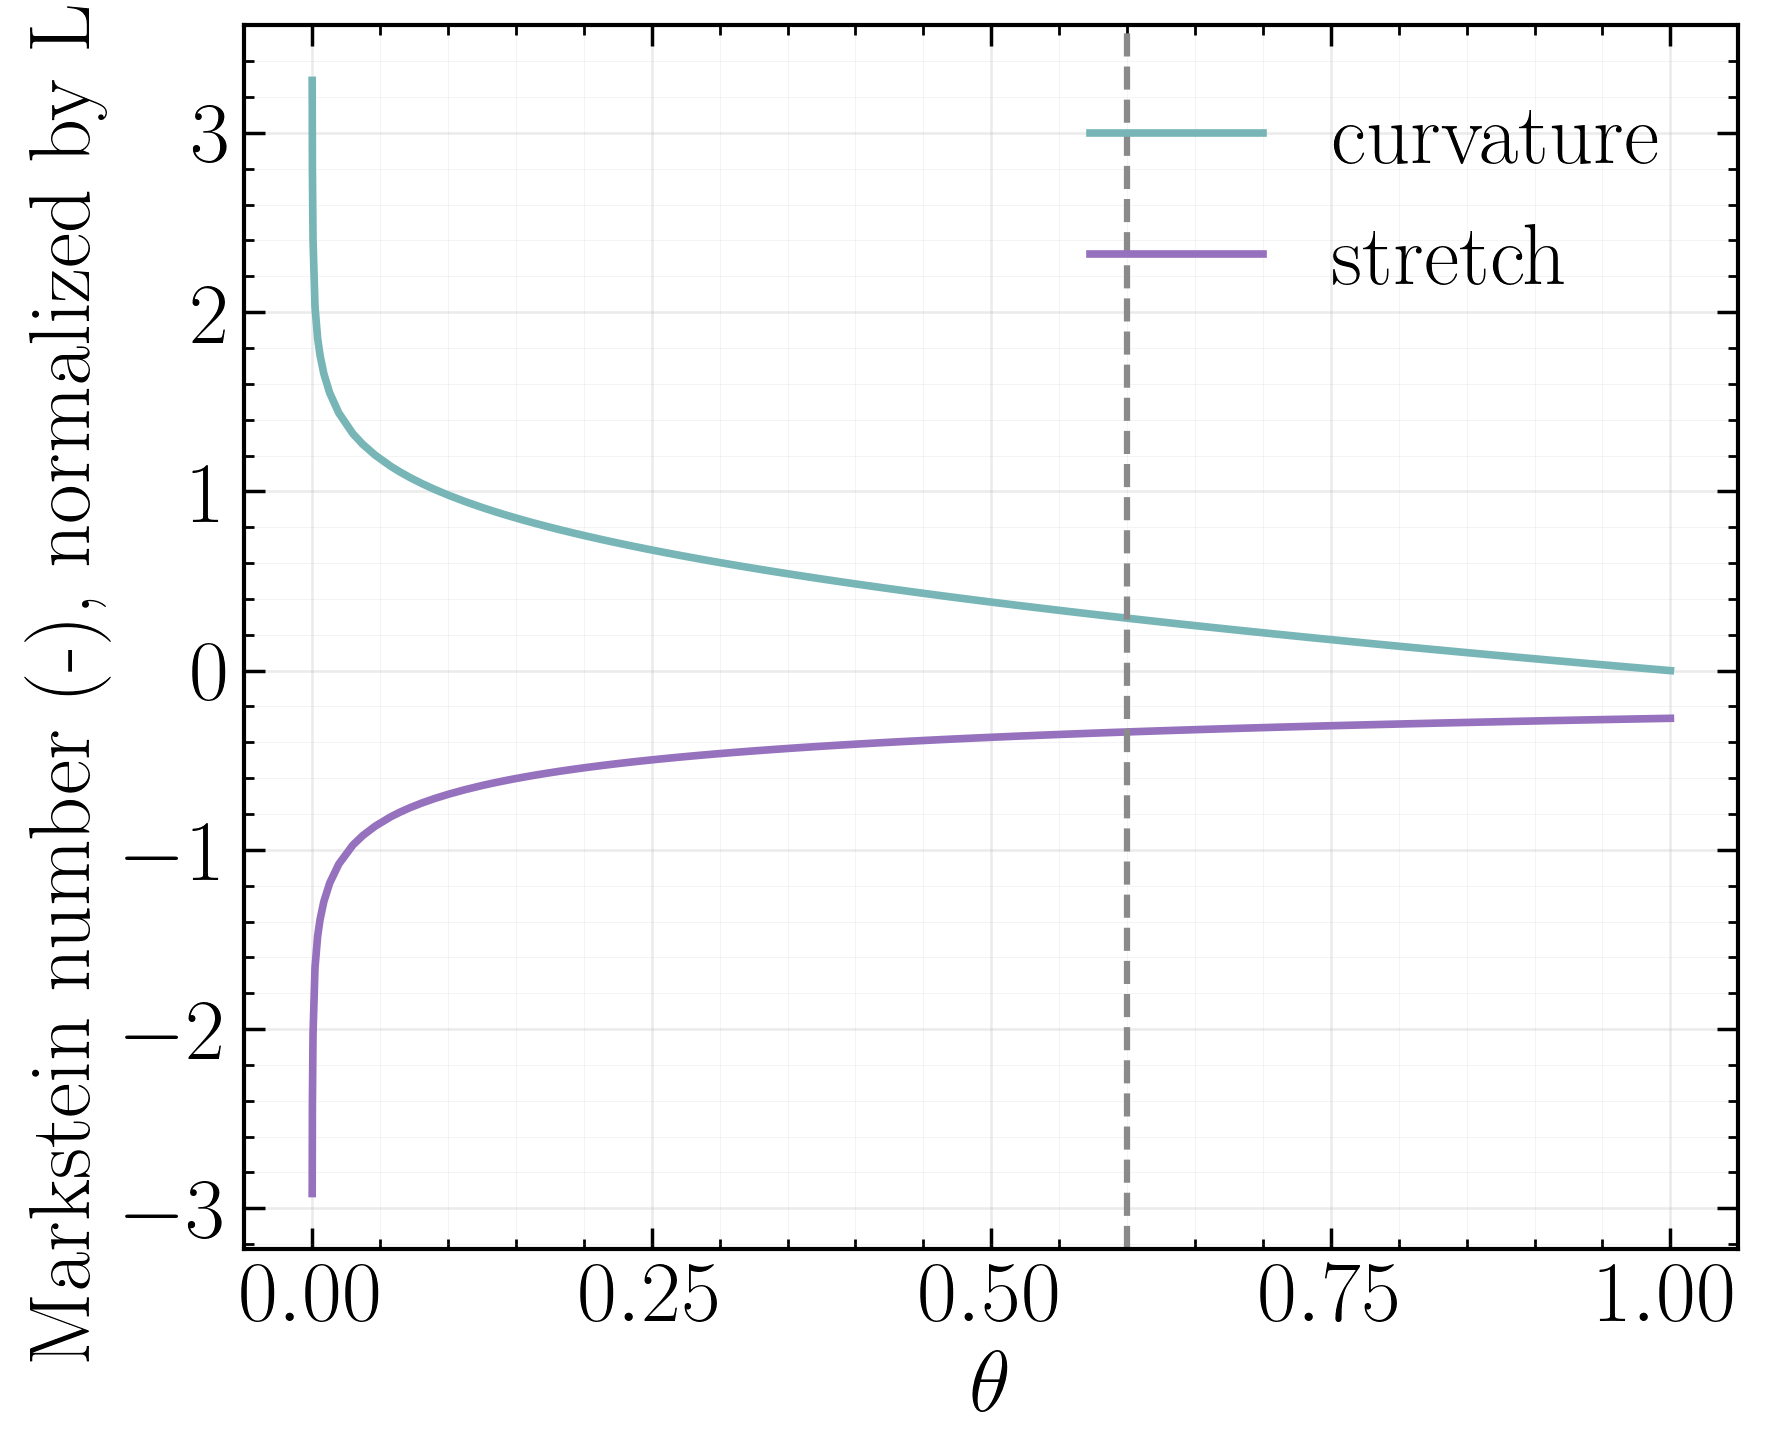

In [6]:
# Plot Chaudhuri/Dave Markstein lengths vs progress variable (optional)
if COMPUTE_PROFILE:
    y1 = M_curv_profile if PLOT_NONDIM else L_curv_profile
    y2 = M_stretch_profile if PLOT_NONDIM else L_stretch_profile

    ylab = f"Markstein number (-), normalized by {L0_name}" if PLOT_NONDIM else "Markstein length (m)"

    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=False)
    ax.plot(progress, y1, color=COLOR_DATA, label='curvature', linewidth=LINE_WIDTH)
    ax.plot(progress, y2, color=COLOR_PRED, label='stretch', linewidth=LINE_WIDTH)

    # Mark the queried c*
    ax.axvline(PROGRESS_QUERY, color=COLOR_LINE, linewidth=1.8, linestyle='--')
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(ylab)
    style_axes(ax)
    ax.legend(frameon=False)

    fig.subplots_adjust(top=FIG_TOP_PAD)

    if SAVE_PLOTS:
        plot_base = PLOT_OUT_DIR / f"markstein_phi_{PHI:.2f}".replace('.', 'p')
        suffix = 'markstein_numbers_vs_progress' if PLOT_NONDIM else 'markstein_lengths_vs_progress'
        save_multi_fig(fig, plot_base, suffix)

    plt.show()
    plt.close(fig)


    phi     Tu           Tb   sigma_T      beta    Le_eff     Gamma
0  0.40  298.0  1389.130040  4.661510  8.166390  0.469653  1.494379
1  0.50  298.0  1595.247147  5.353178  7.362175  0.542557  2.262627
2  0.75  298.0  2060.408793  6.914123  5.995691  0.827679  3.928496
3  1.00  298.0  2378.684092  7.982161  5.310947  1.325000  5.410437


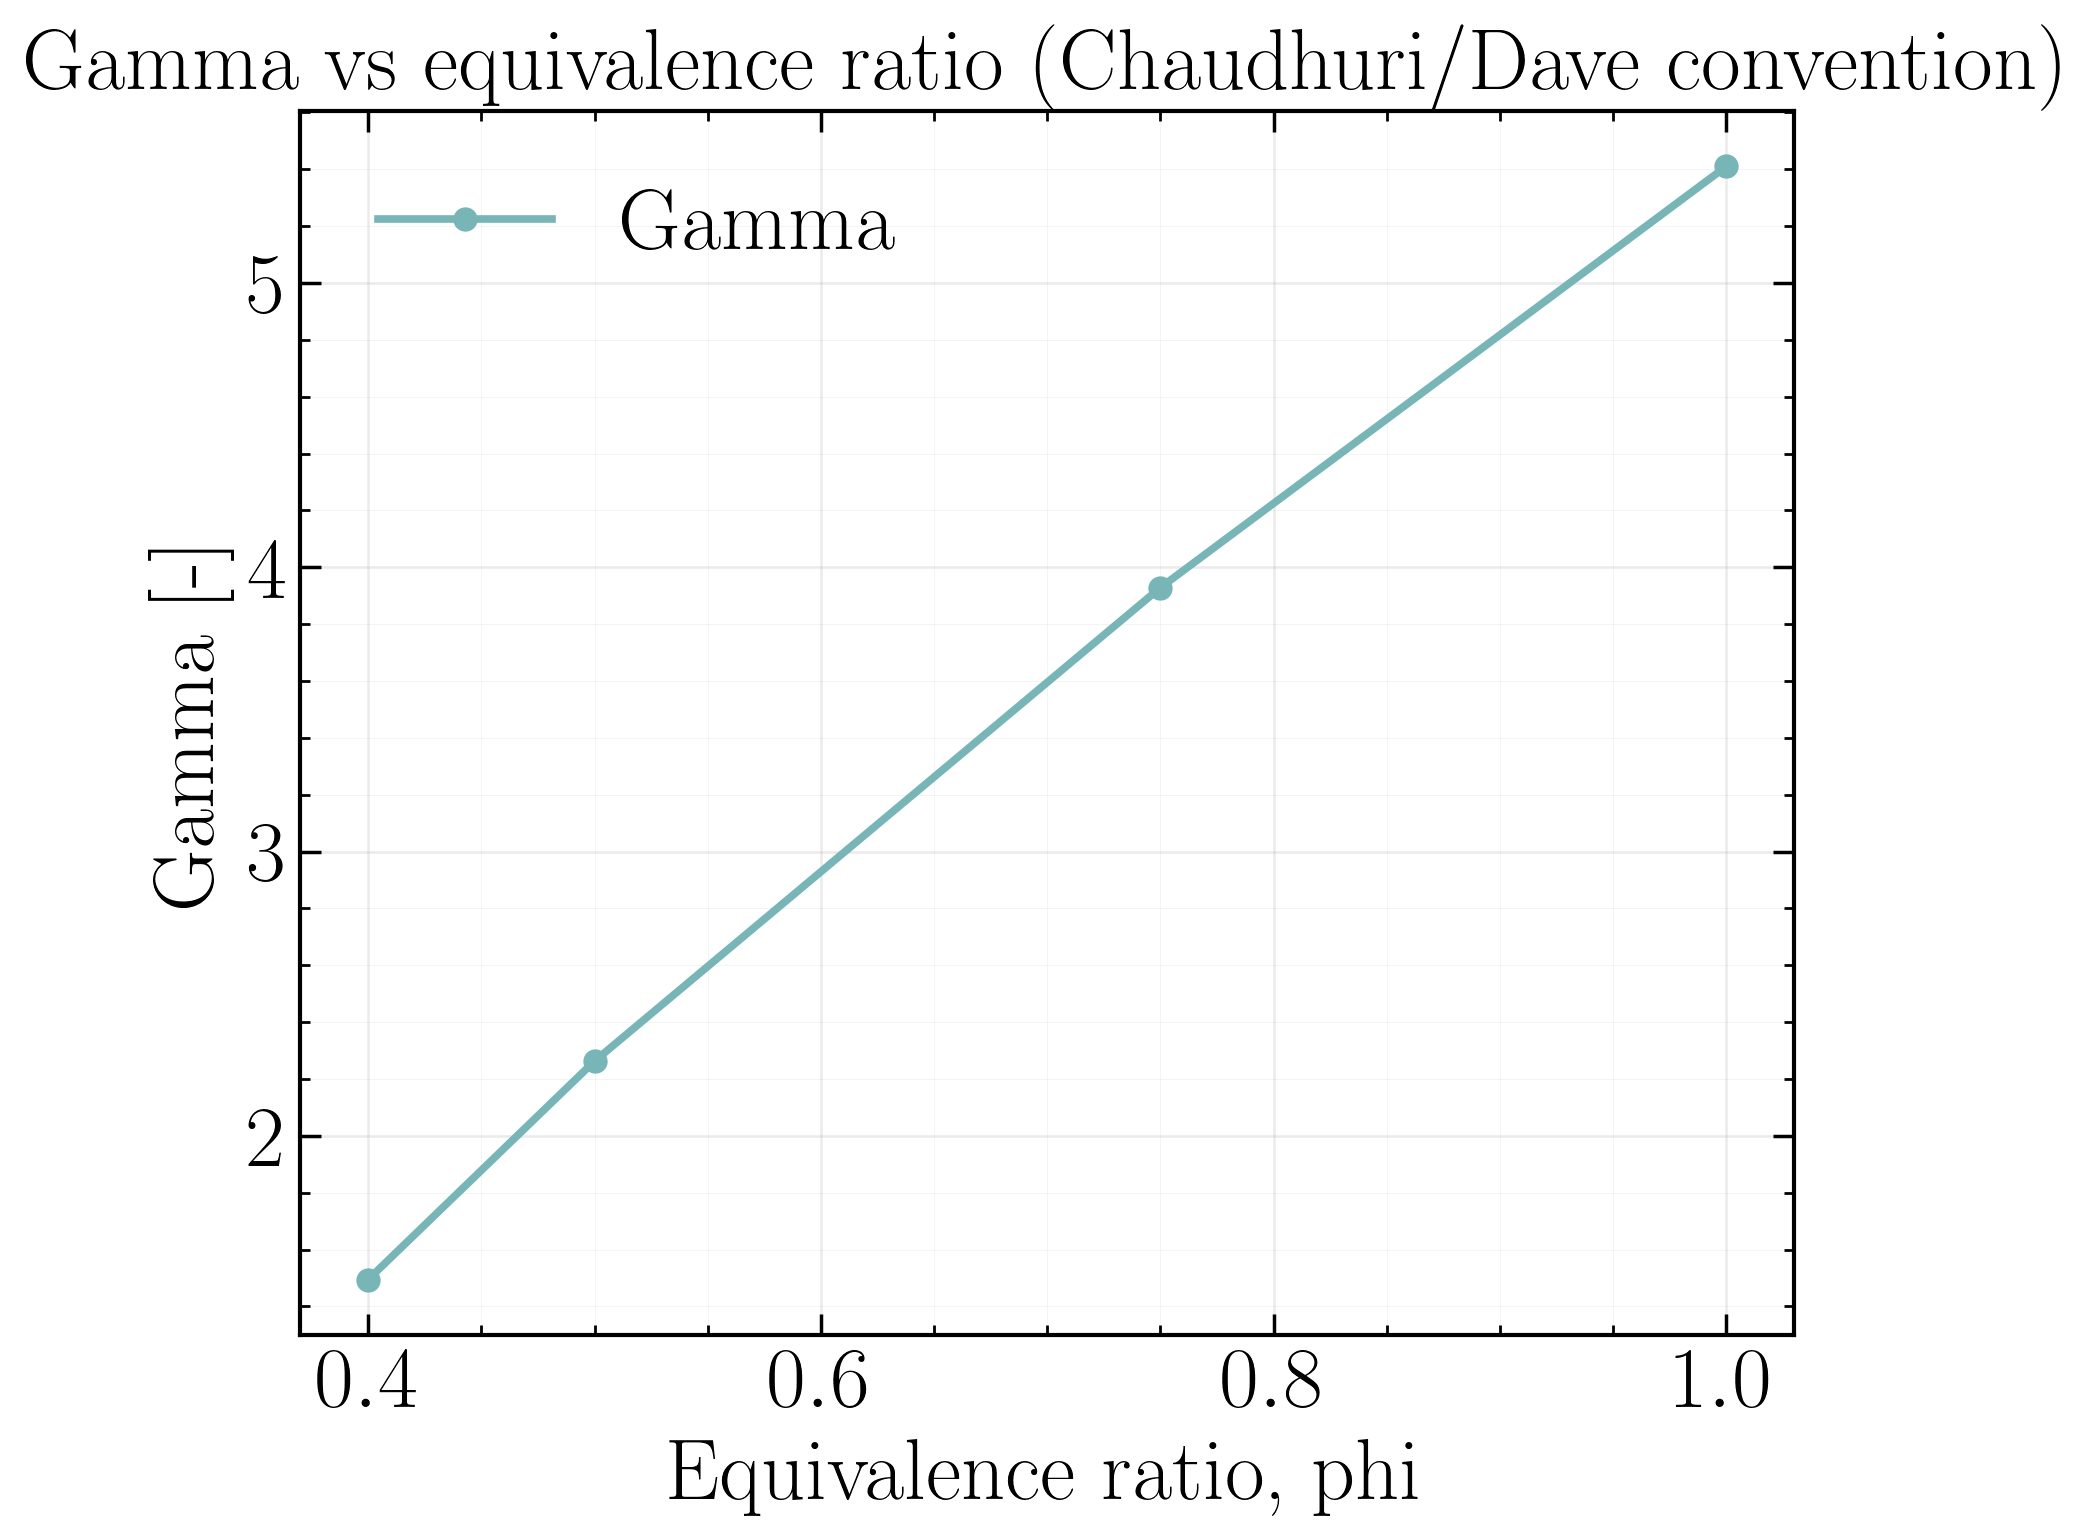

In [7]:
# Sweep equivalence ratios: Gamma vs phi (using Chaudhuri/Dave convention)
PHI_SWEEP = [0.4, 0.5, 0.75, 1.0]
SWEEP_LOGLEVEL = 0

def compute_gamma_for_phi(phi: float) -> dict:
    flame = solve_flame(phi, OXIDIZER, loglevel=SWEEP_LOGLEVEL)
    refs_phi = compute_reference_quantities(flame)

    if USE_FIXED_EA:
        E_a_phi = EA_FIXED_KCAL_PER_MOL * 4184.0 * 1000.0  # J/kmol
    else:
        E_a_phi = estimate_activation_energy(flame)

    beta_phi = E_a_phi * (refs_phi['T_b'] - refs_phi['T_u']) / (
        ct.gas_constant * refs_phi['T_b'] * refs_phi['T_b']
    )

    lewis_phi = lewis_numbers_unburned(phi)
    if USE_FIXED_LEWIS:
        le_fuel_phi = LE_FUEL_FIXED
        le_oxidizer_phi = LE_OXIDIZER_FIXED
    else:
        le_fuel_phi = lewis_phi['Le_fuel']
        le_oxidizer_phi = lewis_phi['Le_oxidizer']

    le_eff_phi = effective_lewis_number(phi, beta_phi, le_fuel_phi, le_oxidizer_phi)

    T = refs_phi['T']
    T_u = refs_phi['T_u']
    T_b = refs_phi['T_b']
    sigma_T = T_b / T_u

    x_full = T / T_u

    if LAMBDA_MODEL.lower() == "powerlaw":
        lam_full = x_full ** LAMBDA_POWER
    else:
        k = refs_phi['k']
        k_u = float(k[0])
        lam_full = k / k_u

    eps = 1e-4
    mask = x_full > (1.0 + eps)
    x = x_full[mask]
    lam = lam_full[mask]

    order = np.argsort(x)
    x = x[order]
    lam = lam[order]

    def cumtrapz_local(y: np.ndarray, x: np.ndarray) -> np.ndarray:
        dx = np.diff(x)
        area = 0.5 * (y[1:] + y[:-1]) * dx
        return np.concatenate(([0.0], np.cumsum(area)))

    f1 = lam / x
    I1 = cumtrapz_local(f1, x)
    I1_total = float(I1[-1])

    f3 = lam / x * np.log((sigma_T - 1.0) / (x - 1.0))
    I3 = cumtrapz_local(f3, x)
    I3_total = float(I3[-1])

    Gamma = (sigma_T / (sigma_T - 1.0)) * I1_total + 0.5 * beta_phi * (le_eff_phi - 1.0) / (sigma_T - 1.0) * I3_total

    return {
        'phi': phi,
        'Tu': T_u,
        'Tb': T_b,
        'sigma_T': sigma_T,
        'beta': beta_phi,
        'Le_eff': le_eff_phi,
        'Gamma': Gamma,
    }

sweep_rows = [compute_gamma_for_phi(phi) for phi in PHI_SWEEP]
sweep_df = pd.DataFrame(sweep_rows)
print(sweep_df)

fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=False)
ax.plot(sweep_df['phi'], sweep_df['Gamma'], color=COLOR_DATA, marker='o', linewidth=LINE_WIDTH, label='Gamma')
ax.set_xlabel('Equivalence ratio, phi')
ax.set_ylabel('Gamma [-]')
ax.set_title('Gamma vs equivalence ratio (Chaudhuri/Dave convention)')
style_axes(ax)
ax.legend(frameon=False)

fig.subplots_adjust(top=FIG_TOP_PAD)

if SAVE_PLOTS:
    plot_base = PLOT_OUT_DIR / f"markstein_phi_{PHI:.2f}".replace('.', 'p')
    save_multi_fig(fig, plot_base, 'gamma_vs_phi')

plt.show()
plt.close(fig)
